In [1]:
import sys
sys.path.insert(0, '../../')
import ccal
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
from sklearn import manifold
import matplotlib.pyplot as plt
import matplotlib.tri as tri

==================== Computational Cancer Analysis Library ====================
<13:12:29> Checking dependencies ...
<13:12:29> Using the following packages:
<13:12:29> 	matplotlib (v1.5.1)
<13:12:29> 	numpy (v1.10.4)
<13:12:29> 	pandas (v0.18.0)
<13:12:29> 	rpy2 (v2.7.9)
<13:12:29> 	scikit-learn (v0.17.1)
<13:12:29> 	scipy (v0.17.0)
<13:12:29> 	seaborn (v0.7.0)


# Parameters

In [150]:
kmin= 1
kmax = 5
kincrement = 1
nclustering = 3
h_matrix = ccal.support.read_gct('../../../hematopoietic_cancer/result/ccle_hema/k9/ccle_hema_k_9_H.gct')
state = 5
exp = 1
CMAP_CATEGORICAL = ccal.visualize.CMAP_CATEGORICAL

# get_states

In [3]:
results = pd.DataFrame(index=range(kmin, kmax + 1, kincrement), columns=list(h_matrix.columns) + ['cophenetic_correlation'])

standardized_h_matrix = ccal.support.standardize_pandas_object(h_matrix)
standardized_and_clipped_h_matrix = standardized_h_matrix.clip(-3, 3)
compared_matrix = ccal.analyze.compare_matrices(standardized_and_clipped_h_matrix, standardized_and_clipped_h_matrix, axis=1)

for k in range(kmin, kmax + 1, kincrement):
    labels = pd.DataFrame(index=range(nclustering), columns=compared_matrix.index)
    for i in range(nclustering):
        ward = AgglomerativeClustering(n_clusters=k)
        ward.fit(compared_matrix)
        labels.iloc[i, :] = ward.labels_

    cooccurences = pd.DataFrame(index=compared_matrix.index, columns=compared_matrix.columns)
    cooccurences.fillna(0, inplace=True)
    for n, s in labels.iterrows():
        for i in s.index:
            for j in s.index:
                if i is j or s.ix[i] == s.ix[j]:
                    cooccurences.ix[i, j] += 1
    cooccurences /= nclustering

    distances = 1 - cooccurences
    link = linkage(distances, method='ward')
    labels = fcluster(link, k, criterion='maxclust')
    cophenetic_correlation = cophenet(link, pdist(distances))[0]
    results.ix[k, h_matrix.columns] = labels
    results.ix[k, 'cophenetic_correlation'] = cophenetic_correlation

<13:12:31> Comparing A3KAW_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (1/166) vs. ...
<13:12:32> Comparing A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (2/166) vs. ...
<13:12:32> Comparing ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (3/166) vs. ...
<13:12:33> Comparing AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (4/166) vs. ...
<13:12:33> Comparing AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (5/166) vs. ...
<13:12:33> Comparing BCP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (6/166) vs. ...
<13:12:34> Comparing BDCM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (7/166) vs. ...
<13:12:34> Comparing BL41_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (8/166) vs. ...
<13:12:35> Comparing BL70_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (9/166) vs. ...
<13:12:35> Comparing BV173_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (10/166) vs. ...
<13:12:36> Comparing CA46_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (11/166) vs. ...
<13:12:36> Comparing CI1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (12/166) vs. ...
<13:12:37> Comparing CMK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE (13/166

# map_onco_gps

In [151]:
mds = manifold.MDS()
components_coordinates = mds.fit_transform(standardized_and_clipped_h_matrix)

In [152]:
delaunay = tri.Triangulation(components_coordinates[:, 0], components_coordinates[:, 1])

In [153]:
samples = pd.DataFrame(index=h_matrix.columns, columns=['label', 'x', 'y', 'color'])

In [154]:
samples.ix[:, 'label'] = results.ix[state, :]

In [155]:
for col_name in h_matrix:
    col = h_matrix.ix[:, col_name]
    third = col.sort_values()[-3]
    col = col.mask(col < third, other=0)
    assert sum(col != 0) == 3
    x = sum(col**exp * components_coordinates[:, 0])/sum(col**exp)
    y = sum(col**exp * components_coordinates[:, 1])/sum(col**exp)
    samples.ix[col_name, ['x', 'y']] = x, y

In [158]:
colors = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=state), cmap=CMAP_CATEGORICAL)
samples.ix[:, 'color'] = samples.ix[:, 'label'].apply(colors.to_rgba)

In [159]:
samples

,label,x,y,color
A3KAW_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,5,-7.2093,-5.29949,"(0.694117665291, 0.349019616842, 0.15686275064..."
A4FUK_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,5,-8.12651,-5.76074,"(0.694117665291, 0.349019616842, 0.15686275064..."
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,3,3.14816,-9.67344,"(0.996862745285, 0.598431378603, 0.17411764860..."
AML193_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,1,-4.30899,7.68645,"(0.598431387544, 0.825098049641, 0.46745100319..."
AMO1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,5,-7.18956,-5.11535,"(0.694117665291, 0.349019616842, 0.15686275064..."
BCP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,5,-6.60788,-5.27384,"(0.694117665291, 0.349019616842, 0.15686275064..."
BDCM_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,2,-7.94172,3.30592,"(0.946666669846, 0.403137269616, 0.40392158329..."
BL41_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,2,2.78915,4.69504,"(0.946666669846, 0.403137269616, 0.40392158329..."
BL70_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,2,4.35799,3.89283,"(0.946666669846, 0.403137269616, 0.40392158329..."
BV173_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,4,9.83294,4.33184,"(0.490980398655, 0.330980396271, 0.65098041296..."


## plot

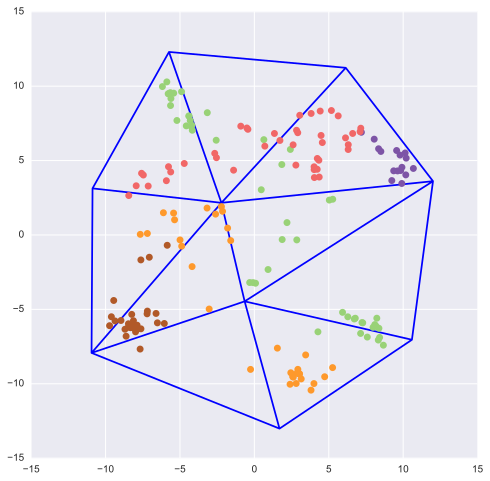

In [160]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.triplot(delaunay, color='blue')

for idx, s in samples.iterrows():
    ax.plot(s.ix['x'], s.ix['y'], marker='o', color=s.ix['color'])

# ax.grid()
# ax.axis('equal')
# ax.set_aspect('equal')